# Link Queue Model Matrix Form

In [3]:
import numpy as np
from scipy.stats import multivariate_normal
class link:
    def __init__(self, density, length, FD):
        self.up = []
        self.k = density
        self.down = []
        self.length = length
        self.FD = FD
        self.C = FD.C
    
    def demand(self):
        # defines the demand function using LQM (CTM)
        k = self.k
        return (min(self.FD.vf * k, self.FD.C)/3600)      # (veh/s)
        
    def supply(self):
        # defines the supply function using LQM (CTM)
        return (min(self.FD.C, self.FD.w*(self.FD.kj-self.k))/3600)   #(veh/s)   
    
    def demand_supply_values(self):
        '''
        Computes the supply and demand of a link
        Note: the supply and demand is in veh/s
        '''
        return self.demand(), self.supply()
    
class fundamental_diagram:
    # define the fundamental diagram for a link
    '''
    The fundamental diagram is a triangular fundamental diagram which takes in 3 parameters:
        1. vf (float, positive): free-flow travel speed (mph)
        2. w (float, positive): congestion wave speed (mph) (should be lower than vf, typically 1/6 - 1/3 of vf)
        3. kj (float, positive): jam density
    '''
    def __init__(self, vf, w, kj):
        self.vf = vf
        self.w = w
        self.kj = kj
        self.kc = kj*w/(vf+w)
        self.C = vf * self.kc
    def demand(self, k):
        # defines the demand function using LQM (CTM)
        return (min(self.vf * k, self.C)/3600)      # (veh/s)
    def supply(self, k):
        # defines the supply function using LQM (CTM)
        return (min(self.C, self.w*(self.kj-k))/3600)   #(veh/s)

In [4]:
def get_ordinary(A, u, l):
    '''
    From the supply and demand, compute the system update equation (matrix)
    x_(k+1) = A x_k + u_k
    Compute A and u_k
    l: indices of the 2 ordinary links ex. [1, 2]
    '''
    l1 = l[0]; l2 = l[1]
    link_1 = link_list[l1]
    link_2 = link_list[l2]  
    d1,s1 = link_1.demand_supply_values()
    d2,s2 = link_2.demand_supply_values()
    g1 = min(d1, s2)
    if g1 == d1:
        # demand of link1 is less than supply of link2
        if d1<link_1.C/3600:
            # demand of link1 is less than capacity (v*k)
            A[l1][l1] += -link_1.FD.vf/3600
            A[l2][l1] += link_1.FD.vf/3600
        else:
            # f2 = g1 = C
            u[l1, 0] += -link_1.C/3600
            u[l2, 0] += link_1.C/3600
    elif s2 < link_2.C/3600:
        A[l2][l2] += -link_2.FD.w /3600
        A[l1][l2] += link_2.FD.w/3600
        u[l1, 0] += -link_2.FD.w * link_2.FD.kj / 3600
        u[l2, 0] += link_2.FD.w * link_2.FD.kj / 3600     
    else:
        u[l1, 0] = u[l1, 0] -link_2.C/3600
        u[l2, 0] += link_2.C/3600
    return A, u

In [5]:
    
def get_merge(A, u, l, alpha_merge = 0.5):
    '''
    From the supply and demand, compute the system update equation (matrix)
    x_(k+1) = A x_k + u_k
    Compute A and u_k
    l: indices of the merging junction links ex. [link1_id, link2_id, link3_id] >-  
    alpha_merge: merging priority, fair merge (0.5) by default
    '''
    l1 = l[0]; l2 = l[1]; l3 = l[2]
    link_1 = link_list[l1]
    link_2 = link_list[l2]
    link_3 = link_list[l3]
    
    d1,s1 = link_1.demand_supply_values()
    d2,s2 = link_2.demand_supply_values()
    d3,s3 = link_3.demand_supply_values()
    f3 = min(d1+d2, s3)
    g1 = min(d1, max(s3-d2, alpha_merge *s3))
    g2 = min(d2, max(s3-d1, (1-alpha_merge) *s3))
    
    # if 1
    if f3 == d1+d2:  # demand is less than supply   
        # if 2
        if d1<link_1.C/3600:  # d1 = k1 v1 (will not involve u)
            A[l3][l1] += link_1.FD.vf/3600
            A[l1][l1] += -link_1.FD.vf/3600
        else: 
            # d1 = C1, need to update u 
            u[l1, 0] += -link_1.C/3600
            u[l3, 0] += link_1.C/3600
        if d2<link_2.C/3600: 
            A[l3][l2] += link_2.FD.vf/3600
            A[l2][l2] += -link_2.FD.vf/3600
        else:
            # d2 = C2, need to update u
            u[l2, 0] += -link_2.C/3600
            u[l3, 0] += link_2.C/3600
    else:  # d1+d2>s3
        # if 1
        if s3<link_3.C/3600:
            # s3 = w3*(kj - k3)
            A[l3][l3] += -link_3.FD.w/3600
            u[l3, 0] += link_3.FD.w*link_3.FD.kj/3600
            
            # if 2
            if g1 == d1:  
                if d1<link_1.C/3600: # g1=k1*v1, g2=s3-d1
                    A[l2][l1] += link_1.FD.vf/3600
                    A[l1][l1] += -link_1.FD.vf/3600
                    A[l2][l3] += link_3.FD.w/3600
                    u[l2, 0] += -link_3.FD.w * link_3.FD.kj /3600
                else:   #g1 = C1, g2 = s3-C1
                    u[l1, 0] += -link_1.C/3600
                    u[l2, 0] += link_1.C/3600 - link_3.FD.w*link_3.FD.kj/3600
                    A[l2][l3] += link_3.FD.w/3600
                    
            elif g2 == d2:  
                if d2<link_2.C/3600: # g2=k2*v2, g1=s3-d2
                    A[l1][l2] += link_2.FD.vf/3600
                    A[l2][l2] += -link_2.FD.vf/3600
                    A[l1][l3] += link_3.FD.w/3600
                    u[l1, 0] += -link_3.FD.w * link_3.FD.kj /3600
                else:   #g1 = C1, g2 = s3-C1
                    u[l2, 0] += -link_2.C/3600
                    u[l1, 0] += link_2.C/3600 - link_3.FD.w*link_3.FD.kj/3600
                    A[l1][l3] += link_3.FD.w/3600    
            
            else:  # g1=g2=1/2 s3 for fair merge
                A[l1][l3] += alpha_merge * link_3.FD.w/3600
                A[l2][l3] += (1-alpha_merge)*link_3.FD.w/3600
                u[l1, 0] += -alpha_merge * link_3.FD.w * link_3.FD.kj / 3600
                u[l2, 0] += -(1-alpha_merge) * link_3.FD.w * link_3.FD.kj / 3600    

        else: 
            # s3>=link_3.C/3600
            u[l3, 0] += link_3.C/3600
            
            if g1 == d1:  
                if d1<link_1.C/3600: # g1=k1*v1, g2=s3-d1
                    A[l2][l1] += link_1.FD.vf/3600
                    A[l1][l1] += -link_1.FD.vf/3600
                    u[l2, 0] += -link_3.C/3600
                else:   #g1 = C1, g2 = s3-C1
                    u[l1, 0] += -link_1.C/3600
                    u[l2, 0] += link_1.C/3600 - link_3.C/3600
                    
            elif g2 == d2:  
                if d2<link_2.C/3600: # g2=k2*v2, g1=s3-d2
                    A[l1][l2] += link_2.FD.vf/3600
                    A[l2][l2] += -link_2.FD.vf/3600
                    u[l1, 0] += -link_3.C/3600
                else:   #g1 = C1, g2 = s3-C1
                    u[l2, 0] += -link_2.C/3600
                    u[l1, 0] += link_2.C/3600 -  link_3.C/3600
            
            else:  # g1=g2=1/2 s3 for fair merge
                u[l1, 0] += -alpha_merge *  link_3.C / 3600
                u[l2, 0] += -(1-alpha_merge) *  link_3.C / 3600 
            
    return A, u      

In [6]:
def get_diverge(A,u, l, r=0.5):
    l1 = l[0]; l2 = l[1]; l3 = l[2]; r12 = r; r13 = 1-r
    link_1 = link_list[l1]
    link_2 = link_list[l2]
    link_3 = link_list[l3]
    d1,s1 = link_1.demand_supply_values()
    d2,s2 = link_2.demand_supply_values()
    d3,s3 = link_3.demand_supply_values()
    g1 = min(d1, s2/r12, s3/r13)
    f2 = r12*g1
    f3 = r13*g1
    
    if g1 == d1:  #all flow can get to downstreams
        if d1<link_1.C/3600:
            A[l1][l1] += -link_1.FD.vf /3600
            A[l2][l1] += link_1.FD.vf * r12 /3600
            A[l3][l1] += link_1.FD.vf * r13 /3600
        else:
            u[l1, 0] += -link_1.C/3600
            u[l2, 0] += link_1.C*r12/3600
            u[l3, 0] += link_1.C*r13/3600
    elif g1 == s2/r12:  #link2 is the bottleneck
        if s2<link_2.C/3600:
            A[l1][l2] += 1/r12 * link_2.FD.w /3600; u[l1, 0] += -1/r12 * link_2.FD.w * link_2.FD.kj  /3600
            A[l2][l2] += -link_2.FD.w/3600;  u[l2, 0] += link_2.FD.w * link_2.FD.kj  /3600
            A[l3][l2] += -r13/r12*link_2.FD.w/3600; u[l3, 0] +=r13/r12 * link_2.FD.w * link_2.FD.kj  /3600
        else:
            u[l1, 0] += -1/r12 * link_2.C/3600
            u[l2, 0] += link_2.C/3600
            u[l3, 0] += r13/r12*link_2.C/3600
            
    else: #link3 is the bottleneck
        if s3<link_3.C/3600:
            A[l1][l3] += 1/r13 * link_3.FD.w /3600; u[l1, 0] += -1/r13 * link_3.FD.w * link_3.FD.kj /3600
            A[l3][l3] += -link_3.FD.w/3600;  u[l3, 0] += link_3.FD.w * link_3.FD.kj  /3600
            A[l2][l3] += -r12/r13*link_3.FD.w/3600; u[l2, 0] +=r13/r12 * link_3.FD.w * link_3.FD.kj /3600
        else: 
            u[l1, 0] += -1/r13 * link_3.C/3600
            u[l2, 0] += link_3.C/3600
            u[l3, 0] += r12/r13*link_3.C/3600
    return A, u

In [7]:
def compute_boundary_flow(i, inflow_list, outflow_list, link_list):
    # get the boundary flow first
    boundary_flow = np.zeros((n,1))
    for j in range(n):
        # find the boundary links
        if inflow_list[i][j] > 0: 
            d_j, s_j = link_list[j].demand_supply_values()
            boundary_flow[j][0] = min(s_j, inflow_list[i][j])
        if outflow_list[i][j] > 0: 
            d_j, s_j = link_list[j].demand_supply_values()
            boundary_flow[j][0] = -min(d_j, outflow_list[i][j])
    return boundary_flow


def check_occurrence(A, u, A_list, A_dict, u_list, u_dict, mode_list, mode_transition_num):
    '''
    Record distinct A, u, and record the occurrence for mode frequency tracking purpose
    '''
    check_flag = 0
    for j in range(len(A_list)):
        A_ = A_list[j]
        if np.all(A_ == A):
            check_flag = 1
            continue
    if check_flag == 0:
        A_list.append(A)
        u_list.append(u)
        A_dict[len(A_list)-1] = 1
        u_dict[len(u_list)-1] = 1
    else:
        A_dict[j] += 1
        u_dict[j] += 1
    # Find the index of A in A_list
    mode = next(i for i, x in enumerate(A_list) if np.array_equal(x, A))
    mode_list.append(mode)
    if mode >= mode_transition_num.shape[0]:
        # Add a new row of zeros
        new_row = np.zeros((1, mode_transition_num.shape[1]))
        mode_transition_num = np.append(mode_transition_num, new_row, axis=0)

        # Add a new column of zeros
        new_column = np.zeros((mode_transition_num.shape[0], 1))
        mode_transition_num = np.append(mode_transition_num, new_column, axis=1)
    
    if len(mode_list) > 1: 
        mode_transition_num[mode_list[-2], mode] += 1
    
    return A_list, A_dict, u_list, u_dict, mode_list, mode_transition_num



def LQM_matrix(inflow_list, outflow_list, network_geometry, link_list, WITH_NOISE=False, alpha_merge=0.5, split_ratio=0.5):
    '''
    boundary_flow: np.array (dim = n) a vector of n dimensions with non-zero elements at the boundary locations
                  defines the flow (veh/s) at each boundary link
    network_geometry: list of list of list, defines the network geometry including ordinary, merge and diverge junctions
                    ex. network >--< [[[3,4]], [[1,2,3]], [[4,5,6]]]
    '''

    link_density = np.array([link_list[i].k for i in range(n)]).reshape(n, 1)
    density_list = list(); boundary_list = list()
    A_list = list(); u_list = list()
    A_dict = {}; u_dict = {}
    mode_list = list()
    mode_transition_num = np.zeros((1, 1)).astype(int)
    
    for i in range(T):    
        # update mode matrix 
        A = np.eye(n)
        # update the Bu term 
        u = np.zeros((n,1))
        # compute noise
        
        noise = (np.random.multivariate_normal(np.zeros(n), Q)).reshape(n,1)
        
        # compute boundary flow 
        boundary_flow = compute_boundary_flow(i, inflow_list, outflow_list, link_list)
        boundary_list.append(boundary_flow)       
        
        # update the matrix elements based on all junction types
        for ordinary_junction_index in network_geometry[0]:
            A, u = get_ordinary(A, u, ordinary_junction_index)  
            
        for merge_junction_index in network_geometry[1]:
            A, u = get_merge(A, u, merge_junction_index, alpha_merge)  
        
        for diverge_junction_index in network_geometry[2]:
            A, u = get_diverge(A, u, diverge_junction_index, split_ratio)  
            
        
        if WITH_NOISE:
            link_density = A @ link_density + u + boundary_flow + noise
        else:
            link_density = A @ link_density + u + boundary_flow
        for j in range(n):
            link_list[j].k = link_density[j, 0]
        # record the results
        density_list.append(link_density)
        
        A_list, A_dict, u_list, u_dict, mode_list, mode_transition_num = check_occurrence(A, u, A_list, A_dict, u_list, u_dict, mode_list, mode_transition_num)
    return density_list, boundary_list, A_list, u_list, mode_list, mode_transition_num, A_dict


def plot_density(density_list, mode_list):
    import matplotlib.pyplot as plt
    plt.rc('font', size=20)
    T = len(density_list)
    t_list = list(range(T))
    
#     for j in range(n):
#         k_list = [i[j][0] for i in density_list]
#         plt.plot(t_list, k_list, label ="k" +str(j)+"(veh/mi)")
    
    # Create the plot

    fig, ax = plt.subplots(figsize=(10, 8)) 
    
    for j in range(n):
        k_list = [i[j][0] for i in density_list]   
        ax.plot(t_list, k_list, label='k'+str(j+1)+" (veh/h)")
    

#     # Fill the background between x=0 and x=1 with red
#     ax.axvspan(0, 1, alpha=0.1, color='red')

#     # Fill the background between x=1 and x=3 with blue
#     ax.axvspan(1, 3, alpha=0.3, color='blue')

    # Define a colormap with different colors for each index
    cmap = plt.cm.get_cmap('viridis', max(mode_list)+1)
    
    start_index = 0
    for end_index in range(1, T):
        if mode_list[end_index]!=mode_list[start_index]:
            ax.axvspan(start_index, end_index-1, alpha=0.3, color=cmap(mode_list[start_index]))
            start_index = end_index
    ax.axvspan(start_index, end_index, alpha=0.3, color=cmap(mode_list[start_index]))         
    
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    #plt.legend(loc="upper left")
    plt.show()
    
    
    
    
def plot_Cov(Cov_list, mode_list):
    import matplotlib.pyplot as plt
    plt.rc('font', size=20)
    T = len(density_list)
    t_list = list(range(T))
    
#     for j in range(n):
#         k_list = [i[j][0] for i in density_list]
#         plt.plot(t_list, k_list, label ="k" +str(j)+"(veh/mi)")
    
    # Create the plot

    fig, ax = plt.subplots(figsize=(10, 8)) 
    Cov_norms = []
    for i in range(T):
        Cov_norms.append(np.linalg.norm(Cov_list[i]))
    
    ax.plot(t_list, Cov_norms, label='norm')
    

#     # Fill the background between x=0 and x=1 with red
#     ax.axvspan(0, 1, alpha=0.1, color='red')

#     # Fill the background between x=1 and x=3 with blue
#     ax.axvspan(1, 3, alpha=0.3, color='blue')

    # Define a colormap with different colors for each index
    cmap = plt.cm.get_cmap('viridis', max(mode_list)+1)
    
    start_index = 0
    for end_index in range(1, T):
        if mode_list[end_index]!=mode_list[start_index]:
            ax.axvspan(start_index, end_index-1, alpha=0.3, color=cmap(mode_list[start_index]))
            start_index = end_index
    ax.axvspan(start_index, end_index, alpha=0.3, color=cmap(mode_list[start_index]))         

    plt.legend(loc="upper left")
    plt.show()

# Estimation

In [10]:
def IMM_filter():
    from scipy.stats import multivariate_normal
    
    x_list = []; mu_list = []; Cov_list = []
    # calculate the mixing probabilities 
    N_m = len(A_list) # number modes
    # initialization
    mu_k = np.ones(N_m)/N_m
    PI = mode_transition_num / np.sum(mode_transition_num, axis=1, keepdims=True)
    for i in range(N_m):
        for j in range(N_m):
            if PI[i, j]<0.001:
                PI[j, j] = PI[j, j] - (0.001-PI[i, j]) 
                PI[i, j] = 0.001
            
    initial_mean = np.zeros(n).reshape(n, 1)
    initial_cov = np.eye(n)

    # get matrix B, all set to identity 
    B = np.eye(n)
    D = np.eye(n)

    R = np.eye(p)

    x_k = list(); Cov_k = list()
    y_prediction = [None] * N_m
    x_0i = [None] * N_m; Cov_0i = [None] * N_m
    x_prediction = [None] * N_m
    Cov_prediction = [None] * N_m

    for i in range(N_m):
        x_k.append(initial_mean)
        Cov_k.append(initial_cov)
        
        
    # filtering starts
    for k in range(3600):
        # mixing step
        ### calculate the mixing probabilities mu_mixing
        mu_mixing = np.zeros((N_m, N_m)) 
        for i in range(N_m):
            mu_i_sum = sum(PI[:, i] * mu_k)
            for j in range(N_m):
                mu_mixing[j, i] = PI[j, i] * mu_k[j] / mu_i_sum
        ### calculate the mixed estimates and covariances

        for i in range(N_m):
            x_0i[i] = 0; Cov_0i[i] = 0
            for j in range(N_m):
                x_0i[i] += mu_mixing[j, i] * x_k[j]
            for j in range(N_m):
                Cov_0i[i] += mu_mixing[j, i] * (Cov_k[j] + (x_k[j] - x_0i[i])@(x_k[j] - x_0i[i]).T)

        # Mode matched prediction update
        for i in range(N_m):
            x_prediction[i] = A_list[i] @ x_0i[i] + u_list[i] + boundary_list[k]

            Cov_prediction[i] = A_list[i] @ Cov_0i[i] @ A_list[i].T + B @ Q @ B.T
            S = C@Cov_prediction[i]@C.T + R
            K = Cov_prediction[i] @ C.T @ np.linalg.inv(S)
            x_k[i] = x_prediction[i] + K@(y_k[k] - C@x_prediction[i])
            Cov_k[i] = Cov_prediction[i] - K@C@Cov_prediction[i]
            y_prediction[i] = C@x_prediction[i]

        # updating model likelihood 
        likelihood_list = []
        temp_sum = []

        for i in range(N_m):
            mvn = multivariate_normal(mean=y_prediction[i].reshape(p,), cov=S)
            likelihood_list.append(mvn.pdf(y_k[k].reshape(p,)))
            temp_s = 0
            for j in range(N_m):
                temp_s += PI[j, i] * mu_k[j]
            temp_sum.append(temp_s)

        likelihood_list = np.array(likelihood_list); temp_sum = np.array(temp_sum)
        mu_k = likelihood_list*temp_sum / sum(likelihood_list*temp_sum)
        
        # record
        x_posterior = 0; Cov_posterior = 0
        for i in range(N_m):
            x_posterior += mu_k[i] * x_k[i]
            Cov_posterior += mu_k[i] * Cov_k[i]
        x_list.append(x_posterior)
        Cov_list.append(Cov_posterior)
        mu_list.append(mu_k)
        
    return x_list, mu_list, Cov_list

In [8]:
def compute_error(x_list, density_list):
    Absolute_percentage_error = 0
    for i in range(len(x_list)):
        err = np.array(x_list[i]) - np.array(density_list[i])
        Absolute_percentage_error += np.sum(abs(err)/np.array(density_list[i]))
    MAPE = Absolute_percentage_error/len(x_list)/n
    return MAPE

def plot_mode_prob(mu_list, mode_list):
    true_mode_prob = list()
    for i in range(T):
        true_mode_prob.append(mu_list[i][mode_list[i]])
    t_list = np.arange(T)
    plt.figure(figsize=(10, 5)) 
    plt.title("True mode probability in IMM filtering")
    plt.plot(t_list, true_mode_prob)

In [9]:
def plot_2densities(density_list, x_list, vect = None):
    import matplotlib.pyplot as plt
    plt.rc('font', size=20)
    T = len(density_list)
    t_list = list(range(T))
    
#     for j in range(n):
#         k_list = [i[j][0] for i in density_list]
#         plt.plot(t_list, k_list, label ="k" +str(j)+"(veh/mi)")
    
    # Create the plot

    fig, ax = plt.subplots(figsize=(10, 8)) 
    
    color_ind = 0
    for j in range(n):
        k1_list = [i[j][0] for i in density_list]   
        k2_list = [i[j][0] for i in x_list]   
        
        if vect is None:
            color = plt.cm.plasma(j / n)
            ax.plot(t_list, k1_list, label='k'+str(j+1)+" (veh/h)", linestyle='-', color=color)
            ax.plot(t_list, k2_list, label='k'+str(j+1)+" (veh/h) predicted", linestyle='--', color=color)
        elif vect[j]==0:
            color = plt.cm.plasma(color_ind / len(np.where(vect == 0)[0]))
            color_ind += 1
            ax.plot(t_list, k1_list, label='k'+str(j+1)+" (veh/h)", linestyle='-', color=color)
            ax.plot(t_list, k2_list, label='k'+str(j+1)+" (veh/h) predicted", linestyle='--', color=color)
            
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Density (veh/mi)')
    # Put the legend outside the plot
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    # Define a colormap with different colors for each index
    cmap = plt.cm.get_cmap('viridis', max(mode_list)+1)
    
    start_index = 0
    for end_index in range(1, T):
        if mode_list[end_index]!=mode_list[start_index]:
            ax.axvspan(start_index, end_index-1, alpha=0.3, color=cmap(mode_list[start_index]))
            start_index = end_index
    ax.axvspan(start_index, end_index, alpha=0.3, color=cmap(mode_list[start_index]))         

    plt.show()

3

# Initialization

In [10]:
T = 3600 # time steps
l = 1  # length of road

# Merge

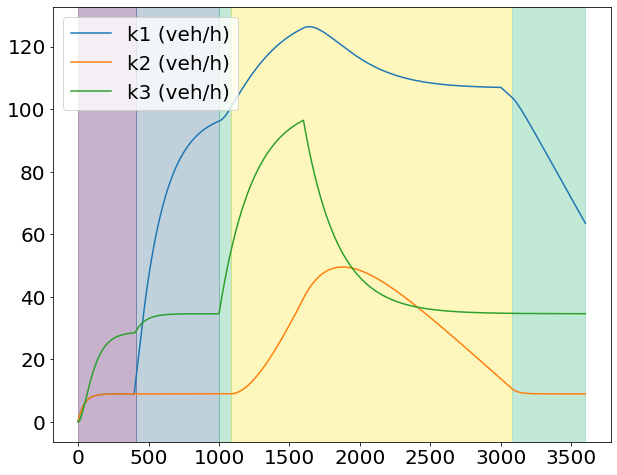

In [18]:
n = 3
Q = np.eye(n)*0.5
R = np.eye(n)
FD1 = fundamental_diagram(80, 20, 150)
FD2 = fundamental_diagram(50, 15, 150)
link_list = list()
link_list.append(link(0, l, FD1))
link_list.append(link(0, l, FD1))
link_list.append(link(0, l, FD2))
network_geometry = [[], [[0,1,2]], []]
inflow_list = []; outflow_list = []
for i in range(T):
    if i < 400 or i > 3000:        
        inflow_list.append(np.array([0.2, 0.2, 0]))
    else:
        inflow_list.append(np.array([0.8,0.2, 0]))
for i in range(T):
    if i > 1000 and i<1600:
        outflow_list.append(np.array([0,0, 0.2]))
    else:
        outflow_list.append(np.array([0,0, 2]))
        
density_list, boundary_list, A_list, u_list, mode_list, mode_transition_num = LQM_matrix(inflow_list, outflow_list, network_geometry, link_list, WITH_NOISE = False)
plot_density(density_list, mode_list)

# Diverge

[[0.97777778 0.         0.        ]
 [0.01111111 1.         0.        ]
 [0.01111111 0.         1.        ]] [[0.]
 [0.]
 [0.]]


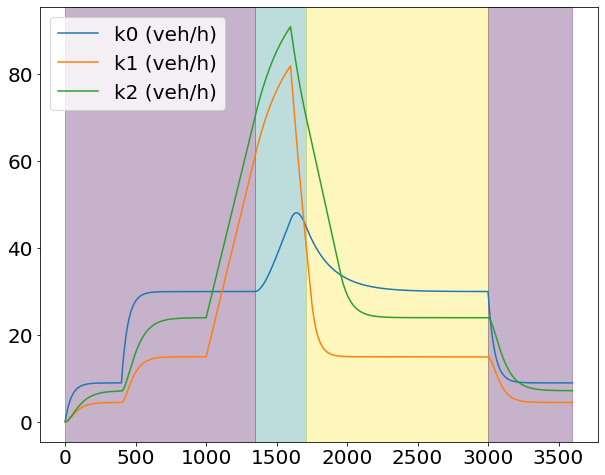

In [195]:
n = 3
Q = np.eye(n)*0.5
R = np.eye(n)
FD1 = fundamental_diagram(80, 20, 150)
FD2 = fundamental_diagram(50, 15, 150)
link_list = list()
link_list.append(link(0, l, FD1))
link_list.append(link(0, l, FD1))
link_list.append(link(0, l, FD2))
network_geometry = [[], [], [[0,1,2]]]
inflow_list = []; outflow_list = []
for i in range(T):
    if i < 400 or i > 3000:        
        inflow_list.append(np.array([0.2, 0, 0]))
    else:
        inflow_list.append(np.array([0.8,0, 0]))
for i in range(T):
    if i > 1000 and i<1600:
        outflow_list.append(np.array([0,0.2, 0.2]))
    else:
        outflow_list.append(np.array([0,2, 2]))
        
density_list, boundary_list, A_list, u_list, mode_list, mode_transition_num = LQM_matrix(inflow_list, outflow_list, network_geometry, link_list, WITH_NOISE = False)
plot_density(density_list, mode_list)

# 6-link network

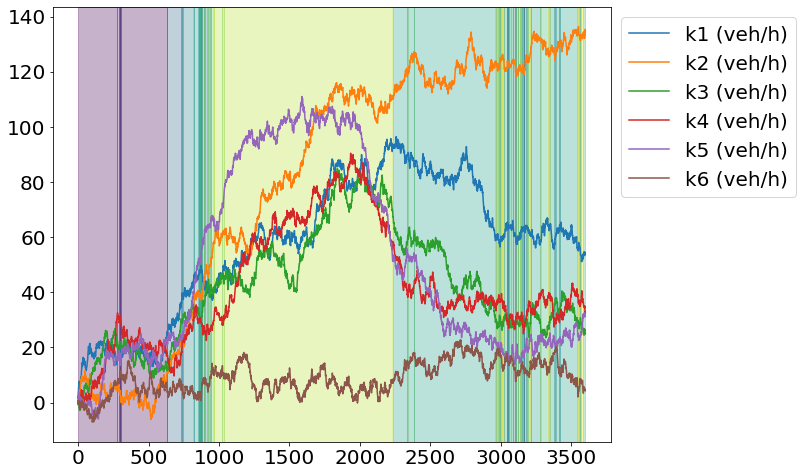

In [552]:
# define network geometry
network_geometry = [[[2,3]], [[0,1,2]], [[3,4,5]]]   # a 6-link network looks like: >--<

n = 6
Q = np.eye(n)*0.5
R = np.eye(n)*0.1
FD1 = fundamental_diagram(65, 16, 150)
FD2 = fundamental_diagram(40, 12, 150)
link_list = list()
link_list.append(link(0, l, FD1))
link_list.append(link(0, l, FD2))
link_list.append(link(0, l, FD1))
link_list.append(link(0, l, FD1))
link_list.append(link(0, l, FD1))
link_list.append(link(0, l, FD2))
np.random.seed(0)

mainlane_merging_priority = 0.8
mainlane_split_ratio = 0.8

inflow_list = []; outflow_list = []
for i in range(T):
    if i < 600 or i > 2000:        
        inflow_list.append(np.array([0.4, 0.1, 0,0,0,0]))
    else:
        inflow_list.append(np.array([0.8, 0.2, 0,0,0,0]))
        
for i in range(T):
    if i > 600 and i<2000:
        outflow_list.append(np.array([0,0,0,0, 0.2, 2]))
    else:
        outflow_list.append(np.array([0,0,0,0, 2, 2]))
        
density_list, boundary_list, A_list, u_list, mode_list, mode_transition_num, A_dict = LQM_matrix(inflow_list, outflow_list, network_geometry, link_list, WITH_NOISE = True, alpha_merge=mainlane_merging_priority, split_ratio=mainlane_split_ratio)
plot_density(density_list, mode_list)

In [111]:

active_mode = []
for element, count in A_dict.items():
    if count>72: # 2% of 3600
        active_mode.append(element)

In [554]:
n = 6
p = 4
sensor_loc = (0,1,4,5)

zero_vector_n = np.zeros(n)
vect = np.zeros(n)
vect[np.array(sensor_loc)]  = 1
C = np.diag(vect)[~np.all(np.diag(vect) == 0, axis=1)]


y_k = list()
for i in range(T):
    y_k.append(C@density_list[i])

x_list, mu_list, Cov_list = IMM_filter()

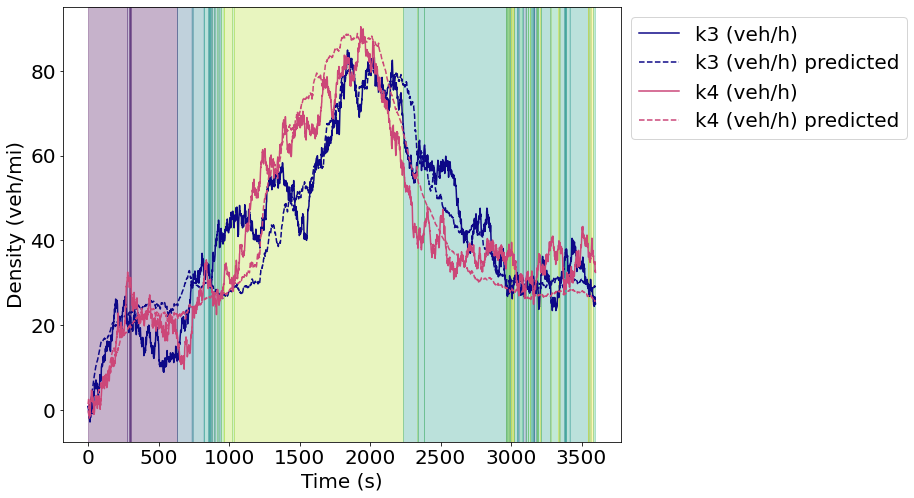

In [555]:
plot_2densities(density_list, x_list, vect)

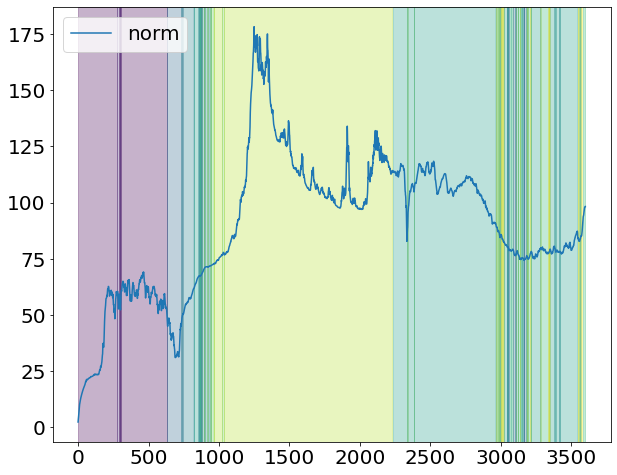

In [36]:
plot_Cov(Cov_list, mode_list)

In [551]:
n = 6
p = 4
all_comb = find_combinations(n, p)

In [605]:
n = 6
p = 4
all_comb = find_combinations(n, p)
observability_scores = []
MAPE_list = []
for sensor_loc in all_comb:   
    start = time.time()
    zero_vector_n = np.zeros(n)
    vect = np.zeros(n)
    vect[np.array(sensor_loc)]  = 1
    _, obj = optimal_sensor_locations(A_list, A_dict, vect)
    C = np.diag(vect)[~np.all(np.diag(vect) == 0, axis=1)]

    y_k = list()
    for i in range(T):
        y_k.append(C@density_list[i])

    x_list, mu_list, Cov_list = IMM_filter()
    
    print("---------------------------------------------------")
    MAPE = np.round(compute_error(x_list, density_list)*100, 4)
    MAPE_list.append(MAPE)
    observability_scores.append(obj)
    print("observe", tuple(np.array(sensor_loc)+1), '| MAPE (%) = ', MAPE, '|   Observable links:', obj[0], 'obs2=',observability_score(A_list, C, w))
    

---------------------------------------------------
observe (1, 2, 3, 4) | MAPE (%) =  62.3495 |   Observable links: 4.579166666666666 obs2= 4.579166666666666
---------------------------------------------------
observe (1, 2, 3, 5) | MAPE (%) =  50.3754 |   Observable links: 4.875277777777777 obs2= 4.875277777777777
---------------------------------------------------
observe (1, 2, 3, 6) | MAPE (%) =  23.0217 |   Observable links: 5.454444444444444 obs2= 4.875277777777777
---------------------------------------------------
observe (1, 2, 4, 5) | MAPE (%) =  55.2719 |   Observable links: 4.822777777777778 obs2= 4.822777777777778
---------------------------------------------------
observe (1, 2, 4, 6) | MAPE (%) =  19.4849 |   Observable links: 5.401944444444444 obs2= 5.401944444444444
---------------------------------------------------
observe (1, 2, 5, 6) | MAPE (%) =  11.5077 |   Observable links: 5.419444444444444 obs2= 5.419444444444444
----------------------------------------------

In [ ]:
def observable_components(A_list, A_dict):
    obs_num = np.zeros(len(A_list))
    

In [ ]:
w = np.fromiter(A_dict.values(), dtype=float)/sum(np.fromiter(A_dict.values(), dtype=float))
for sensor_loc in all_comb:   
    start = time.time()
    vect = np.zeros(n)
    vect[np.array(sensor_loc)]  = 1
    obj = 
    C = np.diag(vect)[~np.all(np.diag(vect) == 0, axis=1)]

    y_k = list()
    for i in range(T):
        y_k.append(C@density_list[i])

    x_list, mu_list, Cov_list = IMM_filter()
    
    print("---------------------------------------------------")
    MAPE = np.round(compute_error(x_list, density_list)*100, 4)
    MAPE_list.append(MAPE)
    observability_scores.append(obj)
    print("observe", tuple(np.array(sensor_loc)+1), '| MAPE (%) = ', MAPE, '|   Observable links:', obj[0], 'time(s) =', time.time()-start)



In [193]:
observability_scores = [i[0] for i in observability_scores]

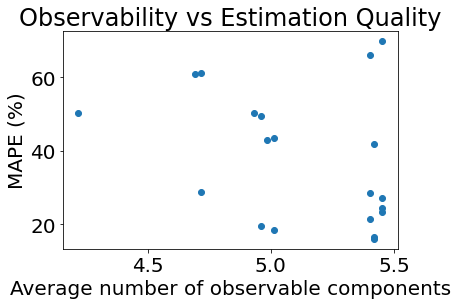

In [238]:
import matplotlib.pyplot as plt
plt.scatter(observability_scores, MAPE_list)

# Add labels and title
plt.xlabel('Average number of observable components')
plt.ylabel('MAPE (%)')
plt.title('Observability vs Estimation Quality')

# Show the plot
plt.show()

In [137]:
C = np.diag(vect)[~np.all(np.diag(vect) == 0, axis=1)]
C

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1.]])

# 2 link case, with congestion

In [549]:
import matplotlib.pyplot as plt

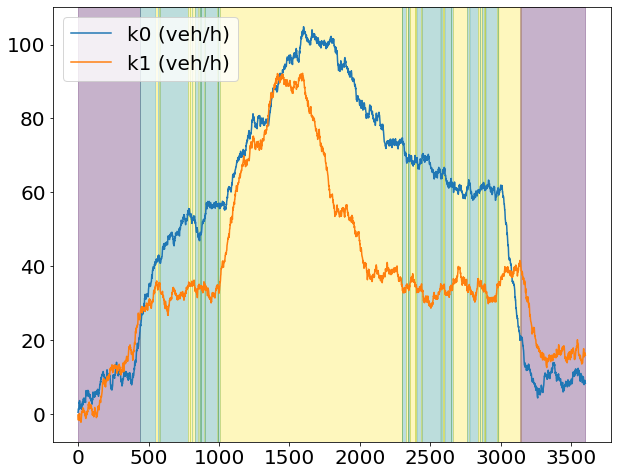

In [973]:
np.random.seed(12)
# define network geometry:
n = 2 # number of links
Q = np.eye(n) * 0.2
FD1 = fundamental_diagram(80, 20, 150)
FD2 = fundamental_diagram(50, 15, 150)
link_list = list()
link_list.append(link(0, l, FD1))
link_list.append(link(0, l, FD2))
network_geometry = [[[0,1]], [], []]


inflow_list = []; outflow_list = []
for i in range(T):
    if i < 400 or i > 3000:        
        inflow_list.append(np.array([0.2, 0]))
    else:
        inflow_list.append(np.array([1, 0]))
for i in range(T):
    if i > 1000 and i<1600:
        outflow_list.append(np.array([0, 0.2]))
    else:
        outflow_list.append(np.array([0, 2]))
        
density_list, boundary_list, A_list, u_list, mode_list, mode_transition_num = LQM_matrix(inflow_list, outflow_list, network_geometry, link_list, WITH_NOISE = True)
plot_density(density_list, mode_list)

#observer 
p = 1
R = np.eye(p) * 0.1
C = np.array([[1,0]])
zero_mean = np.zeros(p)
obs_noise = np.random.multivariate_normal(zero_mean, R, T)

y_k = list()
for i in range(T):
    y_k.append(C@density_list[i] + obs_noise[i])

In [978]:
counter_dict = {element: mode_list.count(element) for element in set(mode_list)}

# Display the counts
for element, count in counter_dict.items():
    print(f"{element}: {count} times")

0: 899 times
1: 948 times
2: 1753 times


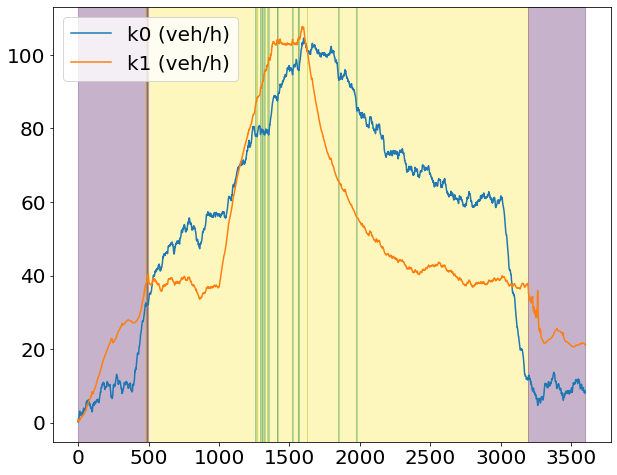

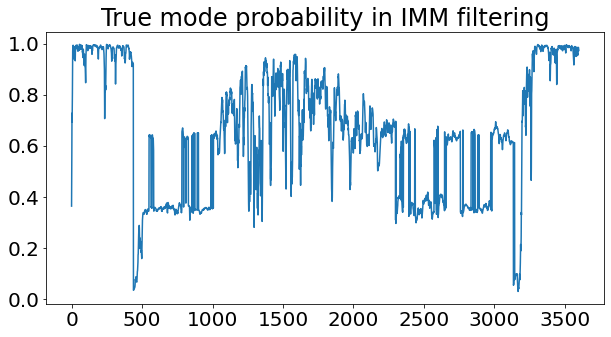

In [976]:
x_list, mu_list = IMM_filter()
mode_list_IMM= [np.argmax(i) for i in mu_list]
plot_density(x_list, mode_list_IMM)
plot_mode_prob(mu_list, mode_list)

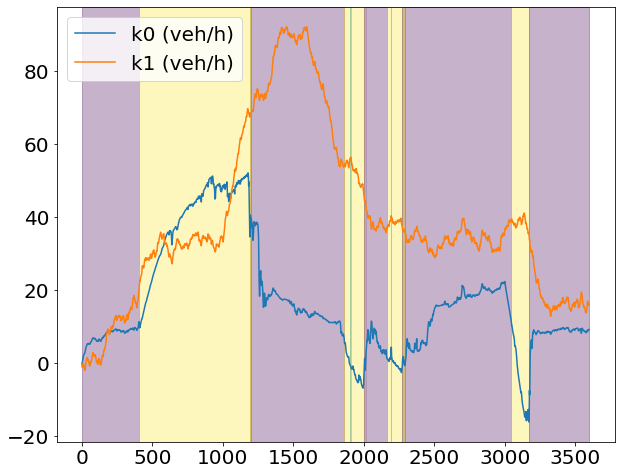

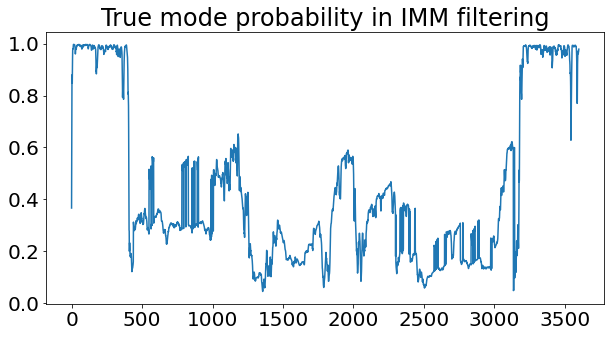

In [977]:
#observer 
p = 1
C = np.array([[0,1]])

y_k = list()
for i in range(T):
    y_k.append(C@density_list[i])
    
x_list, mu_list = IMM_filter()
mode_list_IMM= [np.argmax(i) for i in mu_list]
plot_density(x_list, mode_list_IMM)
plot_mode_prob(mu_list, mode_list)

In [894]:
compute_error(x_list, density_list)

array([[0.39725476],
       [9.50050009]])

# 2 link case, NO congestion

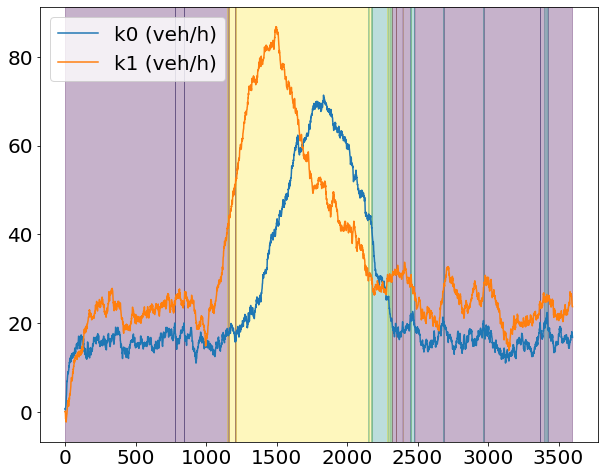

In [903]:
T = 3600
l = 1
Q = np.eye(n)*0.2
# define network geometry:
n = 2 # number of links
FD1 = fundamental_diagram(90, 20, 150)
FD2 = fundamental_diagram(60, 15, 150)
link_list = list()
link_list.append(link(0, l, FD1))
link_list.append(link(0, l, FD2))
network_geometry = [[[0,1]], [], []]


inflow_list = []; outflow_list = []
for i in range(T):
    inflow_list.append(np.array([0.4, 0]))
for i in range(T):
    if i > 1000 and i<1500:
        outflow_list.append(np.array([0, 0.2]))
    else:
        outflow_list.append(np.array([0, 1]))
        
density_list, boundary_list, A_list, u_list, mode_list, mode_transition_num = LQM_matrix(inflow_list, outflow_list, network_geometry, link_list, WITH_NOISE = True)
plot_density(density_list, mode_list)

#observer 
p = 1
C = np.array([[1,0]])

y_k = list()
for i in range(T):
    y_k.append(C@density_list[i])

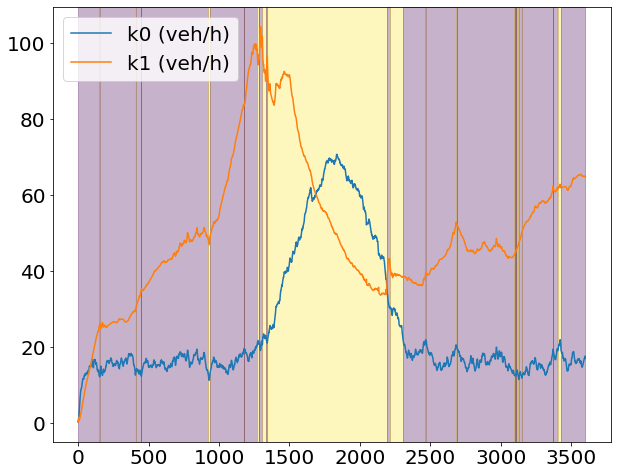

In [904]:
x_list, mu_list = IMM_filter()
mode_list_IMM= [np.argmax(i) for i in mu_list]
plot_density(x_list, mode_list_IMM)

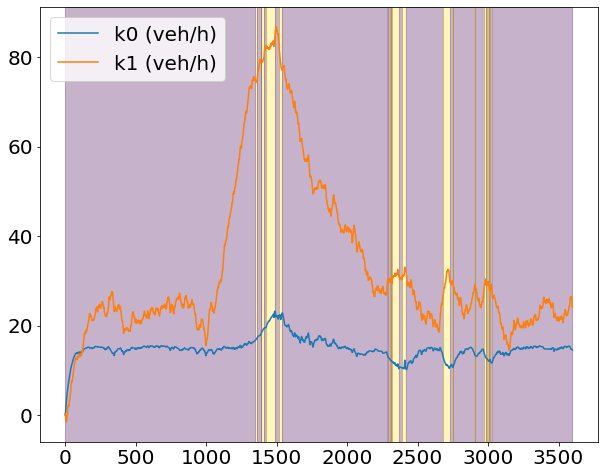

In [906]:
#observer 
p = 1
C = np.array([[0,1]])

y_k = list()
for i in range(T):
    y_k.append(C@density_list[i])
    
x_list, mu_list = IMM_filter()
mode_list_IMM= [np.argmax(i) for i in mu_list]
plot_density(x_list, mode_list_IMM)

## 4-link example

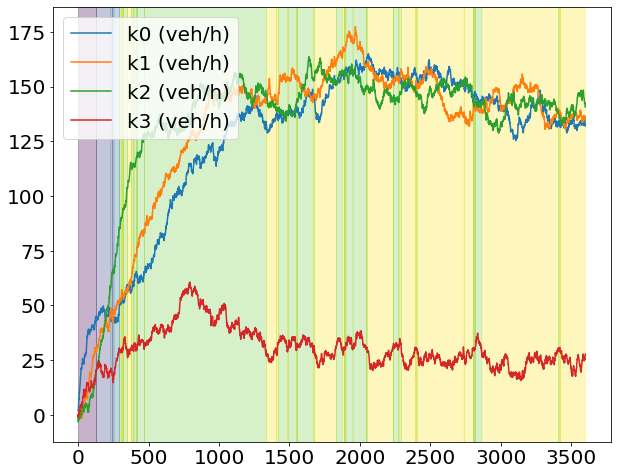

In [908]:
# define network geometry:
n = 4 # number of links
FD3 = fundamental_diagram(60, 20, 200)
FD4 = fundamental_diagram(40, 10, 150)
link_list = list()
link_list.append(link(0, l, FD3))
link_list.append(link(0, l, FD3))
link_list.append(link(0, l, FD3))
link_list.append(link(0, l, FD4))

network_geometry = [[[0,1],[1,2],[2,3]], [], []]

Q = np.eye(n) * 0.5
inflow_list = []; outflow_list = []
for i in range(T):
    if i <= 250:
        inflow_list.append(np.array([3000/3600, 0,0,0]))
    else:
        inflow_list.append(np.array([8000/3600, 0,0,0]))
for i in range(T):
    outflow_list.append(np.array([0,0,0, 10]))
    
#observer 
p = 1
Q = np.eye(n) * 0.5
R = np.eye(p) * 0.1
obs_set = [1]

C = np.empty((0, n))
for i in obs_set:
    unit_vector = np.zeros(n)
    unit_vector[i] = 1
    C =  np.concatenate((C, [unit_vector]))

zero_mean = np.zeros(p)
obs_noise = np.random.multivariate_normal(zero_mean, R, T)


density_list, boundary_list, A_list, u_list, mode_list, mode_transition_num = LQM_matrix(inflow_list, outflow_list, network_geometry, link_list, WITH_NOISE = True)
plot_density(density_list, mode_list)

y_k = list()
for i in range(T):
    y_k.append(C@density_list[i] + obs_noise[i].reshape(p,1))
    

In [812]:
x_list, mu_list = IMM_filter()
compute_error(x_list, density_list)

array([[1310.85364101],
       [ 188.81106315],
       [ 112.00934384],
       [1557.70443023]])

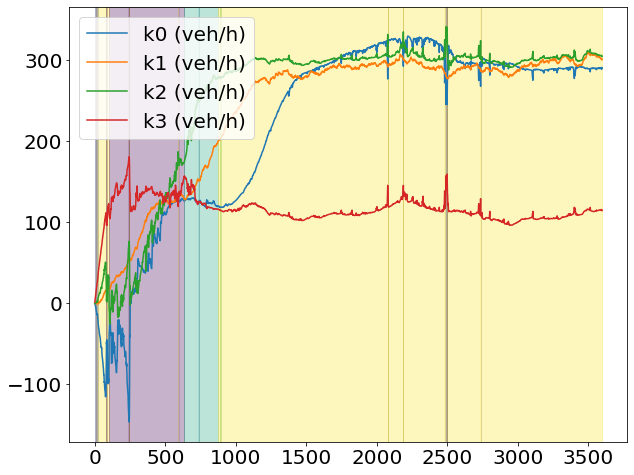

In [813]:
mode_list_IMM= [np.argmax(i) for i in mu_list]
plot_density(x_list, mode_list_IMM)

In [621]:
PI

array([[0.99799489, 0.001     , 0.001     ],
       [0.001     , 0.98922617, 0.01038062],
       [0.001     , 0.00120337, 0.99719495]])

In [435]:
mu_k  = np.array([0.98,0.01,0.01])

In [432]:
PI = np.array([[0.94, 0.03, 0.03],
               [0.03, 0.94, 0.03],
               [0.03, 0.03, 0.94],])

In [458]:
C = np.array([[1,0]])

In [788]:
initial_mean = np.zeros(n).reshape(n, 1)
initial_cov = np.eye(n)

# get matrix B, all set to identity 
B = np.eye(n)
D = np.eye(n)

R = np.eye(p)

x_k = list(); Cov_k = list()
y_prediction = [None] * N_m
x_0i = [None] * N_m; Cov_0i = [None] * N_m
x_prediction = [None] * N_m
Cov_prediction = [None] * N_m

for i in range(N_m):
    x_k.append(initial_mean)
    Cov_k.append(initial_cov)

# sufficient statistics at each time step
'''
Sufficient statistics at each time step
    1. mean x_k, a list of np.arrays (len = N_m)
    2. covariance Cov_k, a list of np.arrays
    3. mode_probability mu_k
'''
from scipy.stats import multivariate_normal

for k in range(3600):
    # mixing step
    ### calculate the mixing probabilities mu_mixing
    mu_mixing = np.zeros((N_m, N_m)) 
    for i in range(N_m):
        mu_i_sum = sum(PI[:, i] * mu_k)
        for j in range(N_m):
            mu_mixing[j, i] = PI[j, i] * mu_k[j] / mu_i_sum
    ### calculate the mixed estimates and covariances

    for i in range(N_m):
        x_0i[i] = 0; Cov_0i[i] = 0
        for j in range(N_m):
            x_0i[i] += mu_mixing[j, i] * x_k[j]
        for j in range(N_m):
            Cov_0i[i] += mu_mixing[j, i] * (Cov_k[j] + (x_k[j] - x_0i[i])@(x_k[j] - x_0i[i]).T)

    # Mode matched prediction update
    for i in range(N_m):
        x_prediction[i] = A_list[i] @ x_0i[i] + u_list[i] + boundary_list[k]
        
        Cov_prediction[i] = A_list[i] @ Cov_0i[i] @ A_list[i].T + B @ Q @ B.T
        S = C@Cov_prediction[i]@C.T + R
        K = Cov_prediction[i] @ C.T @ np.linalg.inv(S)
        x_k[i] = x_prediction[i] + K@(y_k[k] - C@x_prediction[i])
        Cov_k[i] = Cov_prediction[i] - K@C@Cov_prediction[i]
        y_prediction[i] = C@x_prediction[i]
        
        mvn = multivariate_normal(mean=y_prediction[i].reshape(p,), cov=S)
        likelihood_list.append(mvn.pdf(y_k[k].reshape(p,)))

    # updating model likelihood 
    likelihood_list = []
    temp_sum = []

    for i in range(N_m):

        temp_s = 0
        for j in range(N_m):
            temp_s += PI[j, i] * mu_k[j]
        temp_sum.append(temp_s)

    likelihood_list = np.array(likelihood_list); temp_sum = np.array(temp_sum)
    mu_k = likelihood_list*temp_sum / sum(likelihood_list*temp_sum)
    
    

1

In [220]:
k = 0

In [325]:
# vector form
density_array = np.array([0, 0]).reshape(2,1)
FD1 = fundamental_diagram(108, 18, 150)
FD2 = fundamental_diagram(108, 12, 150)
dT = 1

density_list = []
density_array_list = []
inflow1_list = np.ones(3600)
inflow2_list = np.ones(3600)
A_list = []; u_list = []
A_dict = {}


T = len(inflow1_list)

density_list = list()
link1 = link(0, l, FD1)
link2 = link(0, l, FD2)

for i in range(T):
    d1,s1 = sd(link1)
    d2,s2 = sd(link2)

    # inflow
    f1 = min(s1,inflow1_list[i])
    
    g1, f2 = ordinary(link1, link2)
    # outflow 
    g2 = d2
    
    if i > 1000 and i<1500:
        g2 = min(0.2,g2)
    f_list = [f1,f2]
    g_list = [g1,g2]
    f_array = np.array([f1,f2]).reshape(2,1)
    g_array = np.array([g1,g2]).reshape(2,1)
    link_list = [link1,link2]
    
    # update mode matrix 
    A = np.eye(2)
    # update the Bu term 
    u = np.zeros((2,1))
    u[0,0] = f1
    u[1,0] = -g2
#     for links in merge_list:
#         get_merge(links)
#     for links in diverge_list:
#         get_diverge(links,0.5)
    for links in ordinary_list:
        A,u = get_ordinary(A,u, links)    

        
    link_list = update_link(f_list,g_list,link_list)
    density_list.append((link1.k,link2.k))
    
        
    ######################################## change #######################
    #u = ((f_array-g_array -  A@density_array*dT)/l + density_array).reshape(2,1)
    #noise = (np.random.multivariate_normal([0,0], Q)).reshape(2,1)
    density_array = A@density_array + u
    density_array_list.append(density_array)
    #print(u, density_array)
    
    check_flag = 0
    for i in range(len(A_list)):
        A_ = A_list[i]
        if np.all(A_ == A):
            check_flag = 1
            continue
    if check_flag == 0:
        A_list.append(A)
        A_dict[len(A_list)-1] = 1
        u_list.append(u)
    else:
        A_dict[i] +=1

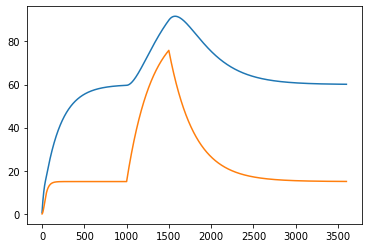

In [12]:
import matplotlib.pyplot as plt
k1_list = [l[0] for l in density_list]
k2_list = [l[1] for l in density_list]
t_list = list(range(3600))
plt.plot(t_list, k1_list, label ="k1")
plt.plot(t_list, k2_list, label = "k2")

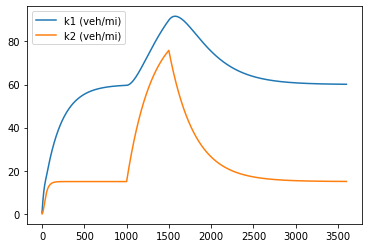

In [13]:
import matplotlib.pyplot as plt
k1_list = [i[0][0] for i in density_array_list]
k2_list = [i[1][0] for i in density_array_list]
t_list = list(range(3600))
plt.plot(t_list, k1_list, label ="k1 (veh/mi)")
plt.plot(t_list, k2_list, label = "k2 (veh/mi)")
plt.legend(loc="upper left")
plt.show()

In [101]:
# IMM filtiering 
n = 2
r = 3 # number of modes
from filterpy.common import kinematic_kf
# transition probability between different modes
trans = np.array([[0.96, 0.02, 0.02], [0.03, 0.96, 0.01], [0.02, 0.02, 0.96]])

mu = np.array([0.33, 0.33, 0.34]).reshape(3, 1)


In [286]:
def mode_update(i, x):
    A = A_list[i]
    f

array([[68.01544117],
       [11.64248289]])

# 22 link Example

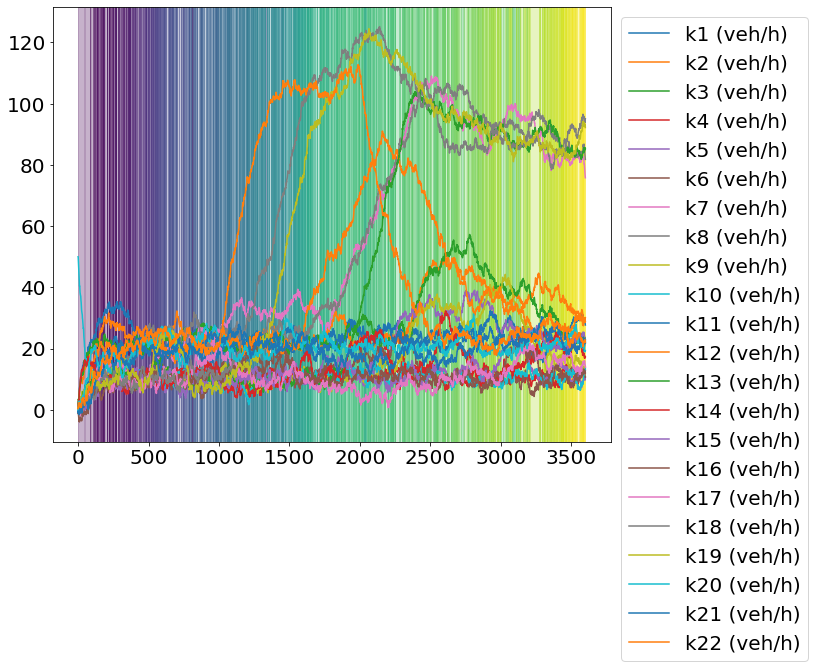

In [15]:
FD1 = fundamental_diagram(108, 18, 150)
FD2 = fundamental_diagram(108, 12, 150)
FD3 = fundamental_diagram(60, 10, 150)
density_list = []
inflow_list = []
inflow1_list = np.ones(3600)
inflow2_list = np.ones(3600)
inflow3_list = np.ones(3600)

n = 22
Q = np.eye(n)*0.2
R = np.eye(n)*2
inflow = np.zeros(n)
inflow[0:3] = 1
for i in range(T):      
    inflow_list.append(inflow)

outflow1 = np.zeros(n)
outflow2 = np.zeros(n)
outflow1[-3:] = 10
outflow2[-3:] = 10
outflow2[-1] = 0.2


inflow_list = []; outflow_list = []
for i in range(T):      
    inflow_list.append(inflow)
    if i > 1000 and i<2000:
        outflow_list.append(outflow2)
    else:
        outflow_list.append(outflow1)


T = len(inflow1_list)
l = 1 #200 meters link length
dT = 1

link1 = link(0, l, FD1)
link2 = link(0, l, FD1)
link3 = link(0, l, FD1)
link4 = link(0, l, FD1)
link5 = link(0, l, FD1)
link6 = link(0, l, FD1)
link7 = link(0, l, FD1)
link8 = link(0, l, FD1)
link9 = link(0, l, FD1)
link10 = link(50, l, FD1)
link11 = link(0, l, FD1)
link12 = link(0, l, FD1)
link13 = link(0, l, FD1)
link14 = link(0, l, FD1)
link15 = link(0, l, FD1)
link16 = link(0, l, FD1)
link17 = link(0, l, FD1)
link18 = link(0, l, FD1)
link19 = link(0, l, FD1)
link20 = link(0, l, FD1)
link21 = link(0, l, FD1)
link22 = link(0, l, FD1)

link_list = [link1,link2,link3,link4, link5, link6,link7,link8,link9,link10,
                 link11,link12,link13,link14, link15, link16,link17,link18,link19,link20,link21,link22]


network_geometry = ([[3, 9], [9, 13], [8, 12], [12, 18]],
 [[4, 5, 10], [6, 7, 11], [13, 14, 19], [15, 16, 20], [17, 18, 21]],
 [[0, 3, 4], [1, 5, 6], [2, 7, 8], [10, 14, 15], [11, 16, 17]])

density_list, boundary_list, A_list, u_list, mode_list, mode_transition_num, A_dict = LQM_matrix(inflow_list, outflow_list, network_geometry, link_list, WITH_NOISE = True)

plot_density(density_list, mode_list)

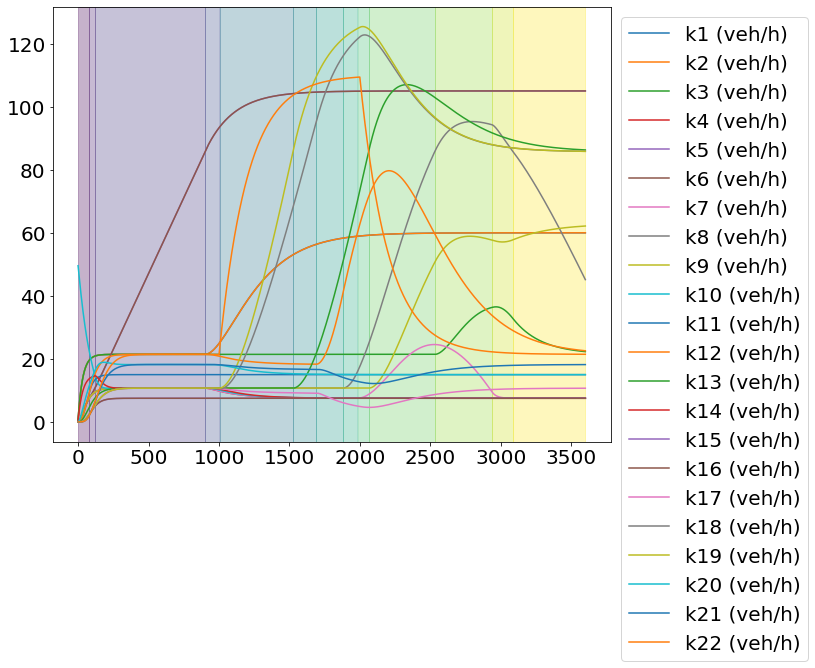

In [16]:

link1 = link(0, l, FD1)
link2 = link(0, l, FD1)
link3 = link(0, l, FD1)
link4 = link(0, l, FD1)
link5 = link(0, l, FD1)
link6 = link(0, l, FD1)
link7 = link(0, l, FD1)
link8 = link(0, l, FD1)
link9 = link(0, l, FD1)
link10 = link(50, l, FD2)
link11 = link(0, l, FD2)
link12 = link(0, l, FD1)
link13 = link(0, l, FD1)
link14 = link(0, l, FD1)
link15 = link(0, l, FD1)
link16 = link(0, l, FD1)
link17 = link(0, l, FD1)
link18 = link(0, l, FD1)
link19 = link(0, l, FD1)
link20 = link(0, l, FD1)
link21 = link(0, l, FD1)
link22 = link(0, l, FD1)

link_list = [link1,link2,link3,link4, link5, link6,link7,link8,link9,link10,
                 link11,link12,link13,link14, link15, link16,link17,link18,link19,link20,link21,link22]


network_geometry = ([[3, 9], [9, 13], [8, 12], [12, 18]],
 [[4, 5, 10], [6, 7, 11], [13, 14, 19], [15, 16, 20], [17, 18, 21]],
 [[0, 3, 4], [1, 5, 6], [2, 7, 8], [10, 14, 15], [11, 16, 17]])

density_list1, boundary_list1, A_list1, u_list1, mode_list1, mode_transition_num1, A_dict1 = LQM_matrix(inflow_list, outflow_list, network_geometry, link_list, WITH_NOISE = False)

plot_density(density_list1, mode_list1)

In [336]:
max(mode_list1)

13

In [17]:
from scipy.stats import multivariate_normal

def compute_PI(A_list, mode_transition_num):
    N_m = len(A_list) # number modes
    # initialization
    PI = mode_transition_num / np.sum(mode_transition_num, axis=1, keepdims=True)
    for i in range(N_m):
        for j in range(N_m):
            if PI[i, j]<0.01:
                PI[j, j] = PI[j, j] - (0.01-PI[i, j]) 
                PI[i, j] = 0.01
    return PI

def compute_PI_001(A_list, mode_transition_num):
    N_m = len(A_list) # number modes
    # initialization
    PI = mode_transition_num / np.sum(mode_transition_num, axis=1, keepdims=True)
    for i in range(N_m):
        for j in range(N_m):
            if PI[i, j]<0.001:
                PI[j, j] = PI[j, j] - (0.001-PI[i, j]) 
                PI[i, j] = 0.001
    return PI

def IMM_filter_reduced(A_list, PI):
    x_list = []; mu_list = []; Cov_list = []
    # calculate the mixing probabilities 
    N_m = len(A_list) # number modes
    mu_k = np.ones(N_m)/N_m
            
    initial_mean = np.zeros(n).reshape(n, 1)
    initial_cov = np.eye(n) 

    # get matrix B, all set to identity 

    R = np.eye(p)*1

    x_k = list(); Cov_k = list()
    y_prediction = [None] * N_m
    x_0i = [None] * N_m; Cov_0i = [None] * N_m
    x_prediction = [None] * N_m
    Cov_prediction = [None] * N_m

    for i in range(N_m):
        x_k.append(initial_mean)
        Cov_k.append(initial_cov)
        
    # filtering starts
    for k in range(3600):
        # mixing step
        ### calculate the mixing probabilities mu_mixing
        mu_mixing = np.zeros((N_m, N_m)) 
        for i in range(N_m):
            mu_i_sum = sum(PI[:, i] * mu_k)
            for j in range(N_m):
                mu_mixing[j, i] = PI[j, i] * mu_k[j] / mu_i_sum
        ### calculate the mixed estimates and covariances

        for i in range(N_m):
            x_0i[i] = 0; Cov_0i[i] = 0
            for j in range(N_m):
                x_0i[i] += mu_mixing[j, i] * x_k[j]
            for j in range(N_m):
                Cov_0i[i] += mu_mixing[j, i] * (Cov_k[j] + (x_k[j] - x_0i[i])@(x_k[j] - x_0i[i]).T)

                
        # updating model likelihood 
        likelihood_list = []
        temp_sum = []
        # Mode matched prediction update
        for i in range(N_m):
            x_prediction[i] = A_list[i] @ x_0i[i] + u_list[i] + boundary_list[k]

            #Cov_prediction[i] = A_list[i] @ Cov_0i[i] @ A_list[i].T + B @ Q @ B.T
            Cov_prediction[i] = A_list[i] @ Cov_0i[i] @ A_list[i].T + Q
            
            S = C@Cov_prediction[i]@C.T + R
            K = Cov_prediction[i] @ C.T @ np.linalg.inv(S)
            x_k[i] = x_prediction[i] + K@(y_k[k] - C@x_prediction[i])
            Cov_k[i] = Cov_prediction[i] - K@C@Cov_prediction[i]
            y_prediction[i] = C@x_prediction[i]
        
       
                
            mvn = multivariate_normal(mean=y_prediction[i].reshape(p,), cov=S)
            likelihood_list.append(mvn.pdf(y_k[k].reshape(p,)))

            

        for i in range(N_m):

            temp_s = 0
            for j in range(N_m):
                temp_s += PI[j, i] * mu_k[j]
            temp_sum.append(temp_s)

        likelihood_list = np.array(likelihood_list); temp_sum = np.array(temp_sum)
        mu_k = likelihood_list*temp_sum / sum(likelihood_list*temp_sum)
        
        # record
        x_posterior = 0; Cov_posterior = 0
        for i in range(N_m):
            x_posterior += mu_k[i] * x_k[i]
        x_list.append(x_posterior)
        mu_list.append(mu_k)
        
    return x_list, mu_list

In [518]:
# Set precision to 4
x_list, mu_list = IMM_filter_reduced(A_list1,PI)


ValueError: the input matrix must be positive semidefinite

In [54]:
active_mode = []
for element, count in A_dict.items():
    if count>36: # 1% of 3600
        active_mode.append(element)
A_list_new = []
u_list_new = []
for i in active_mode:
    A_list_new.append(A_list[i])
    u_list_new.append(u_list[i])
A_list = A_list_new
u_list = u_list_new

In [459]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) >= 0)

In [337]:
n = 22
sensor_loc = (0,1,2,19,20,21)
p = len(sensor_loc)

zero_vector_n = np.zeros(n)
vect = np.zeros(n)
vect[np.array(sensor_loc)]  = 1
C = np.diag(vect)[~np.all(np.diag(vect) == 0, axis=1)]


y_k = list()
for i in range(T):
    y_k.append(C@density_list[i])

PI = compute_PI(A_list1, mode_transition_num1)
    
x_list, mu_list = IMM_filter_reduced(A_list1,PI)

In [181]:
compute_error(x_list, density_list)

0.14444575302340798

In [381]:
C

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,

In [182]:
optimal_sensor_loc, obj = optimal_sensor_locations(A_list, A_dict)

In [150]:

def optimal_sensor_locations(A_list, A_dict, observe_list = None):
    import numpy as np
    import pandas as pd
    import cvxpy as cp
    K = len(A_list) # number of modes
    p = 4 # number of sensors to place
    # define variables
    z = cp.Variable(n, boolean=True)
    x = cp.Variable((K,n))
    
    A = []
    for matrix in A_list:
        # Replace non-zero elements with 1
        matrix_01 = np.where(matrix != 0, 1, matrix)
        A.append(matrix_01 - np.diag(np.diagonal(matrix_01)))
    A = np.array(A)
    w = np.fromiter(A_dict.values(), dtype=float)/sum(np.fromiter(A_dict.values(), dtype=float))
    
    # define constraints & objectives
    constraints = []
    ones = np.ones(n).reshape(n,1)
    for k in range(K):
        constraints += [ones.T @ z >= p, ones.T @ z <= p]
        constraints += [z<=1]
        constraints += [z>=0]
        constraints += [x[k]>=0]

        #constraints += [x[k]>=z]
        constraints += [x[k]<=1]
        #constraints += [A_start[k]@x[k] <= A_end[k]@x[k]]
        constraints += [x[k] <= (A[k].T)@x[k] + z]
    if observe_list is not None:
        constraints += [z>=observe_list]

    objective = cp.Maximize(w.T@(x@ones))
    
    prob = cp.Problem(objective, constraints)
    prob.solve()
    
    return z.value, w.T@(x.value@ones)



In [18]:
from itertools import combinations

def find_combinations(n, k):
    # Generate all combinations of k elements from a sequence of n elements
    all_combinations = list(combinations(range(n), k))
    return all_combinations




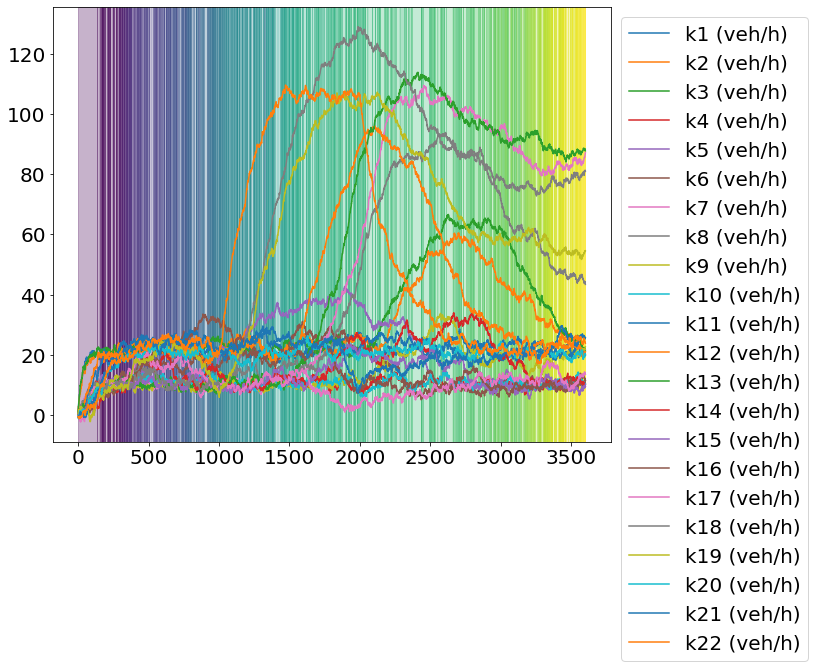

In [19]:
np.random.seed(10)
FD1 = fundamental_diagram(108, 18, 150)
FD2 = fundamental_diagram(108, 12, 150)
FD3 = fundamental_diagram(60, 10, 150)
density_list = []
inflow1_list = np.ones(3600)
inflow2_list = np.ones(3600)
inflow3_list = np.ones(3600)

n = 22
Q = np.eye(n)*0.1
R = np.eye(n)*0.2
inflow = np.zeros(n)
inflow[0:3] = 1
for i in range(T):      
    inflow_list.append(inflow)

outflow1 = np.zeros(n)
outflow2 = np.zeros(n)
outflow1[-3:] = 10
outflow2[-3:] = 10
outflow2[-1] = 0.2


inflow_list = []; outflow_list = []
for i in range(T):      
    inflow_list.append(inflow)
    if i > 1000 and i<2000:
        outflow_list.append(outflow2)
    else:
        outflow_list.append(outflow1)


T = len(inflow1_list)
l = 1 #200 meters link length
dT = 1

link1 = link(0, l, FD1)
link2 = link(0, l, FD1)
link3 = link(0, l, FD1)
link4 = link(0, l, FD2)
link5 = link(0, l, FD1)
link6 = link(0, l, FD2)
link7 = link(0, l, FD1)
link8 = link(0, l, FD2)
link9 = link(0, l, FD1)
link10 = link(0, l, FD1)
link11 = link(0, l, FD1)
link12 = link(0, l, FD1)
link13 = link(0, l, FD1)
link14 = link(0, l, FD1)
link15 = link(0, l, FD2)
link16 = link(0, l, FD1)
link17 = link(0, l, FD2)
link18 = link(0, l, FD1)
link19 = link(0, l, FD2)
link20 = link(0, l, FD1)
link21 = link(0, l, FD1)
link22 = link(0, l, FD1)

link_list = [link1,link2,link3,link4, link5, link6,link7,link8,link9,link10,
                 link11,link12,link13,link14, link15, link16,link17,link18,link19,link20,link21,link22]


network_geometry = ([[3, 9], [9, 13], [8, 12], [12, 18]],
 [[4, 5, 10], [6, 7, 11], [13, 14, 19], [15, 16, 20], [17, 18, 21]],
 [[0, 3, 4], [1, 5, 6], [2, 7, 8], [10, 14, 15], [11, 16, 17]])

density_list, boundary_list, A_list, u_list, mode_list, mode_transition_num, A_dict = LQM_matrix(inflow_list, outflow_list, network_geometry, link_list, WITH_NOISE = True)

plot_density(density_list, mode_list)

# active mode only 

In [324]:
def active_mode(A_list,A_dict, u_list, mode_list, mode_transition_num):
    active_mode = []
    for element, count in A_dict.items():
        if count>36: # 1% of 3600
            active_mode.append(element)
    A_list_active = []
    u_list_active = []
    for i in active_mode:
        A_list_active.append(A_list[i])
        u_list_active.append(u_list[i])
    mode_transition_num_active = mode_transition_num[active_mode,:][:, active_mode]
    mode_transition_num_active += np.eye(len(active_mode)) 
    return A_list_active, u_list_active, mode_transition_num_active

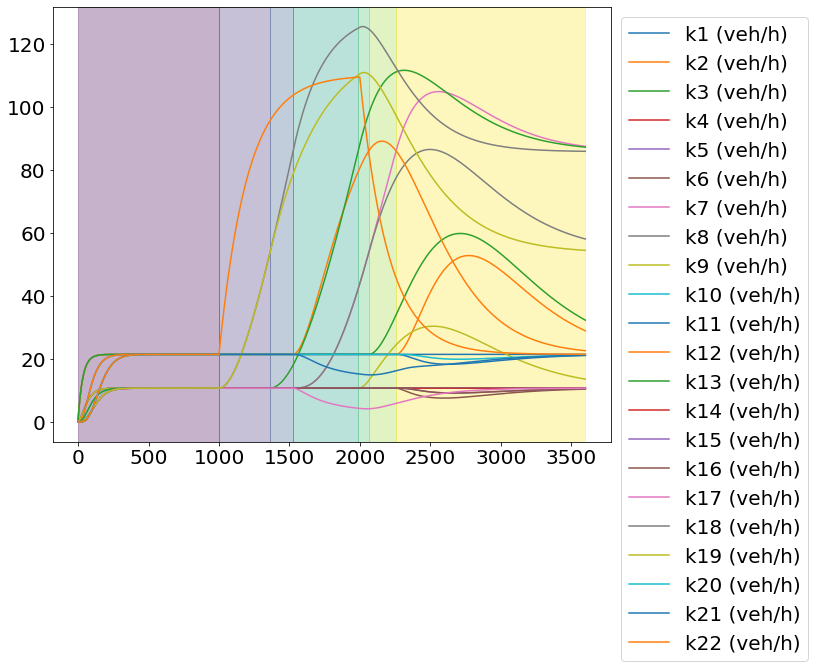

In [32]:

link1 = link(0, l, FD1)
link2 = link(0, l, FD1)
link3 = link(0, l, FD1)
link4 = link(0, l, FD2)
link5 = link(0, l, FD1)
link6 = link(0, l, FD2)
link7 = link(0, l, FD1)
link8 = link(0, l, FD2)
link9 = link(0, l, FD1)
link10 = link(0, l, FD1)
link11 = link(0, l, FD1)
link12 = link(0, l, FD1)
link13 = link(0, l, FD1)
link14 = link(0, l, FD1)
link15 = link(0, l, FD2)
link16 = link(0, l, FD1)
link17 = link(0, l, FD2)
link18 = link(0, l, FD1)
link19 = link(0, l, FD2)
link20 = link(0, l, FD1)
link21 = link(0, l, FD1)
link22 = link(0, l, FD1)

link_list = [link1,link2,link3,link4, link5, link6,link7,link8,link9,link10,
                 link11,link12,link13,link14, link15, link16,link17,link18,link19,link20,link21,link22]


network_geometry = ([[3, 9], [9, 13], [8, 12], [12, 18]],
 [[4, 5, 10], [6, 7, 11], [13, 14, 19], [15, 16, 20], [17, 18, 21]],
 [[0, 3, 4], [1, 5, 6], [2, 7, 8], [10, 14, 15], [11, 16, 17]])

density_list1, boundary_list1, A_list1, u_list1, mode_list1, mode_transition_num1, A_dict1 = LQM_matrix(inflow_list, outflow_list, network_geometry, link_list, WITH_NOISE = False)

plot_density(density_list1, mode_list1)

# Compute NOW

In [23]:
n = 22
sensor_loc = (1,2, 19,20,21)
p = len(sensor_loc)

zero_vector_n = np.zeros(n)
vect = np.zeros(n)
vect[np.array(sensor_loc)]  = 1
C = np.diag(vect)[~np.all(np.diag(vect) == 0, axis=1)]

y_k = list()
for i in range(T):
    y_k.append(C@density_list[i])

# A_list_active, u_list_active, mode_transition_num_active = active_mode(A_list1,A_dict1, u_list1, mode_list1, mode_transition_num1)
# PI = compute_PI(A_list_active, mode_transition_num_active)
# x_list, mu_list = IMM_filter_reduced(A_list_active, PI)

PI = compute_PI(A_list1, mode_transition_num1)
x_list, mu_list = IMM_filter_reduced(A_list1, PI)


In [372]:
compute_error(x_list, density_list)

0.4070405518081387

In [28]:
def compute_PI(A_list, mode_transition_num):
    N_m = len(A_list) # number modes
    # initialization
    mode_transition_num += np.eye(mode_transition_num.shape[0])
    PI = mode_transition_num / np.sum(mode_transition_num, axis=1, keepdims=True)
    for i in range(N_m):
        for j in range(N_m):
            if PI[i, j]<0.005:
                PI[j, j] = PI[j, j] - (0.005-PI[i, j]) 
                PI[i, j] = 0.005
    return PI


import time

PI = compute_PI(A_list1, mode_transition_num1)
start = time.time()

n = 22
sensor_loc = (0,1,2,3,4,5,6,7,8,9,11, 12,13,14,15,16,18,19,20,21)
p = len(sensor_loc)

zero_vector_n = np.zeros(n)
vect = np.zeros(n)
vect[np.array(sensor_loc)]  = 1
C = np.diag(vect)[~np.all(np.diag(vect) == 0, axis=1)]


y_k = list()
for i in range(T):
    y_k.append(C@density_list[i])


x_list, mu_list = IMM_filter_reduced(A_list1,PI)

print(time.time()-start)

16.62776279449463


In [29]:
compute_error(x_list, density_list)

0.0893882415458508

In [25]:
PI


array([[ 0.964002  ,  0.005     ,  0.005     ,  0.005     ,  0.005     ,
         0.005     ,  0.005     ,  0.005     ],
       [ 0.005     ,  0.96322023,  0.005     ,  0.005     ,  0.005     ,
         0.005     ,  0.005     ,  0.005     ],
       [ 0.005     ,  0.005     ,  0.96168022,  0.00609756,  0.005     ,
         0.005     ,  0.005     ,  0.005     ],
       [ 0.005     ,  0.005     ,  0.005     , -0.015     ,  1.        ,
         0.005     ,  0.005     ,  0.005     ],
       [ 0.005     ,  0.005     ,  0.005     ,  0.005     ,  0.96782609,
         0.005     ,  0.005     ,  0.005     ],
       [ 0.005     ,  0.005     ,  0.005     ,  0.005     ,  0.005     ,
         0.95401602,  0.01315789,  0.005     ],
       [ 0.005     ,  0.005     ,  0.005     ,  0.005     ,  0.005     ,
         0.005     ,  0.96481865,  0.00518135],
       [ 0.005     ,  0.005     ,  0.005     ,  0.005     ,  0.005     ,
         0.005     ,  0.005     ,  0.97      ]])

In [ ]:
n = 22
p = 20
all_comb = find_combinations(n, p)
PI = compute_PI(A_list1, mode_transition_num1)

observability_scores = []
MAPE_list = []
for sensor_loc in all_comb:   
    start = time.time()
    vect = np.zeros(n)
    vect[np.array(sensor_loc)]  = 1
    C = np.diag(vect)[~np.all(np.diag(vect) == 0, axis=1)]

    y_k = list()
    for i in range(T):
        y_k.append(C@density_list[i])

    x_list, mu_list = IMM_filter_reduced(A_list1,PI)
    
    print("---------------------------------------------------")
    MAPE = np.round(compute_error(x_list, density_list)*100, 4)
    MAPE_list.append(MAPE)
    observability_scores.append(obj)
    print("observe", tuple(np.array(sensor_loc)+1), '| MAPE (%) = ', MAPE, 'time(s) =', time.time()-start)
    

In [604]:
w = np.fromiter(A_dict.values(), dtype=float)/sum(np.fromiter(A_dict.values(), dtype=float))
from numpy.linalg import matrix_power
def observability_score(A_list, C, w):
    observable_component_num_list = []
    for temp_matrix in A_list:
        observable_component_num = np.sum((C@matrix_power(temp_matrix, 20)).sum(axis = 0)>0)
        observable_component_num_list.append(observable_component_num)
    return(sum(np.array(observable_component_num_list)*w))

In [603]:
observable_component_num

4

In [599]:
temp_matrix

array([[1.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 1.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 1.    , 0.0044, 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.9956, 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 1.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    , 1.    ]])

In [600]:
C

array([[0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]])

In [598]:
C@matrix_power(temp_matrix, 20)

array([[0.    , 0.    , 1.    , 0.0852, 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.9148, 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 1.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    , 1.    ]])

In [565]:
    observable_component_num_list = []
    for temp_matrix in A_list:
        observable_component_num = np.sum((C@matrix_power(temp_matrix, 20)).sum(axis = 0)>0)
        observable_component_num_list.append(observable_component_num)

In [590]:
observable_component_num_list
sum(np.array(observable_component_num)*w)

4.0

In [579]:
np.round(w,3)

array([0.076, 0.099, 0.   , 0.028, 0.024, 0.014, 0.002, 0.023, 0.556,
       0.177])

In [586]:
observable_component_num_list

[5, 5, 5, 5, 5, 5, 5, 5, 5, 4]

In [572]:
C

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.]])